In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import os
import shutil
import random

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

In [33]:
data_dir = 'backup_data/dataset-resized'

categories = ["BATTERY", "BIOLOGICAL", "CLOTHES","CARDBOARD", "GLASS", "METAL", "PAPER", "PLASTIC", "NON_RECYCLE", "SHOES"]

In [34]:
# Creating lists for file paths and labels
filepaths = []
labels = []
classlist = os.listdir(data_dir)
for kelass in classlist:
    classpath = os.path.join(data_dir, kelass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(kelass)

In [35]:
# Creating a DataFrame from file paths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())

                                           filepaths   labels
0   backup_data/dataset-resized\battery\battery1.jpg  battery
1  backup_data/dataset-resized\battery\battery10.jpg  battery
2  backup_data/dataset-resized\battery\battery100...  battery
3  backup_data/dataset-resized\battery\battery101...  battery
4  backup_data/dataset-resized\battery\battery102...  battery
labels
shoes          1977
glass          1905
clothes        1865
paper          1644
plastic        1347
cardboard      1294
metal          1179
biological      985
battery         945
non_recycle     834
Name: count, dtype: int64


In [36]:
# Splitting data into train, validation, and test sets
train_split = .8
test_split = .1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))


train_df length: 11180 test_df length: 1397 valid_df length: 1398


In [37]:
# Preprocessing dataset
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

test batch size: 11 test steps: 127


In [38]:
#augmentation
gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

Found 11180 validated image filenames belonging to 10 classes.
Found 1398 validated image filenames belonging to 10 classes.
Found 1397 validated image filenames belonging to 10 classes.
['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'non_recycle', 'paper', 'plastic', 'shoes']


In [39]:
# Image augmentation
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [40]:
#Creating generators for train, validation, and test sets
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 11180 validated image filenames belonging to 10 classes.
Found 1398 validated image filenames belonging to 10 classes.
Found 1397 validated image filenames belonging to 10 classes.


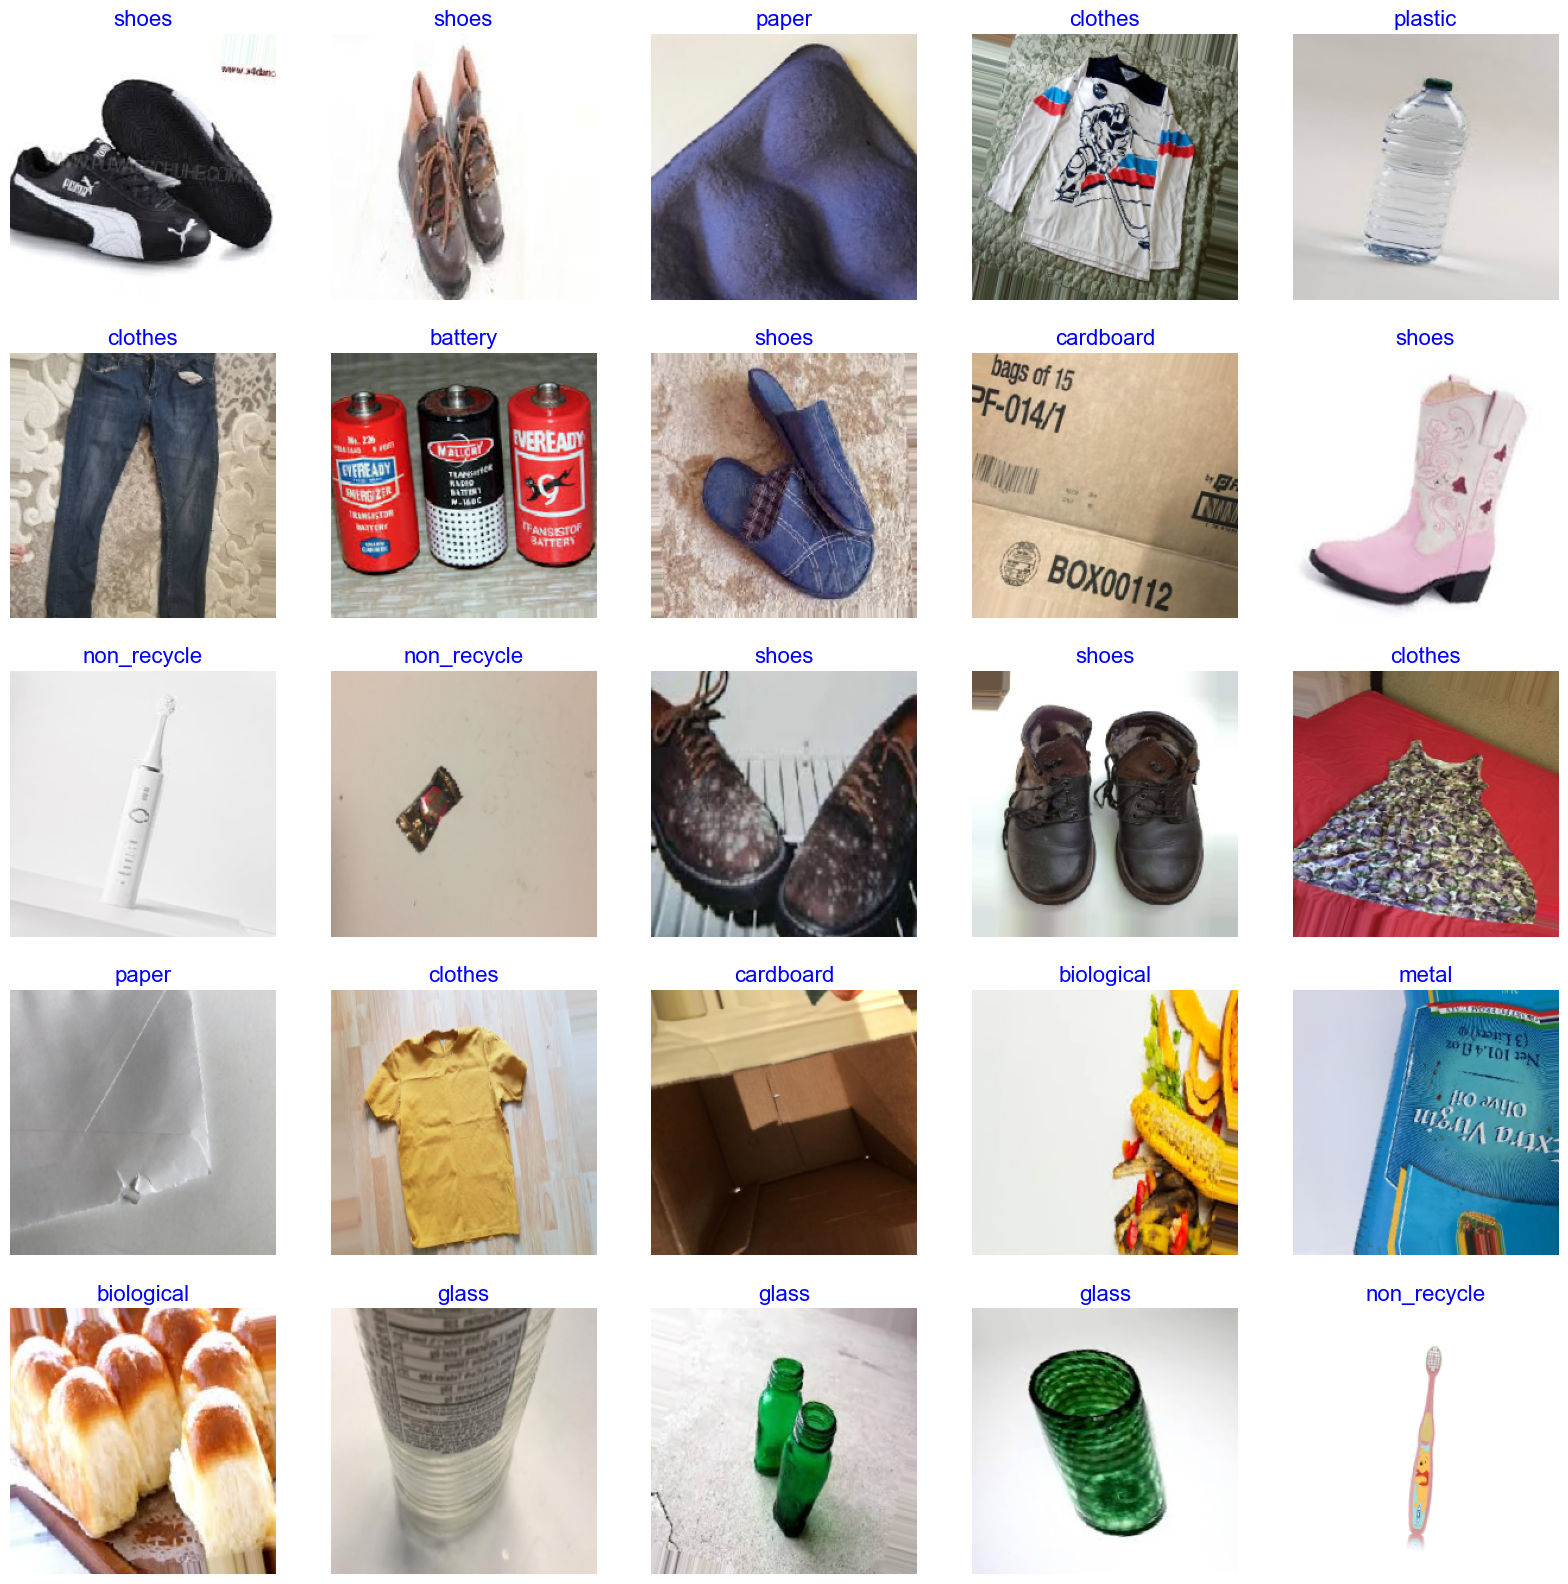

In [44]:
# Visualizing some sample images
def show_image_samples(gen):
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [50]:
# Build the model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)
model = Sequential([
    base_model,  
    Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'),  
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')  
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │     1,364,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,364,864 (5.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,364,864 (5.21 MB)

In [13]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping, checkpoint])

In [4]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [5]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

    tf.saved_model.save(model, 'saved_model')

NameError: name 'tf' is not defined